## Part 1 - Fuzzy Logic Controller Design and Implementation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import skfuzzy as sf
import skfuzzy.control as sf_ctrl
import matplotlib.pyplot as plt
import random
from pyswarm import pso
from scipy.optimize import differential_evolution

In [2]:
# Define universe ranges for inputs and outputs
temp_range = np.arange(0, 41, 1)  # Temperature from 0°C to 40°C
illumination_range = np.arange(0, 101, 1)  # Light levels in lumens from 0 to 100
humidity_range = np.arange(0, 101, 1)  # Humidity from 0% to 100%

In [3]:
# Define fuzzy variables for inputs
temp_input = sf_ctrl.Antecedent(temp_range, 'temp_input')
illumination_input = sf_ctrl.Antecedent(illumination_range, 'illumination_input')
humidity_input = sf_ctrl.Antecedent(humidity_range, 'humidity_input')

In [4]:
# Define fuzzy variables for outputs
heating_output = sf_ctrl.Consequent(np.arange(0, 101, 1), 'heating_output')
illumination_output = sf_ctrl.Consequent(np.arange(0, 101, 1), 'illumination_output')
fan_output = sf_ctrl.Consequent(np.arange(0, 101, 1), 'fan_output')

In [5]:
# Apply chromosome to define fuzzy sets dynamically
def map_chromosome_to_fuzzy(chromosome_data):
    # Apply to temperature fuzzy sets
    temp_input['low'] = sf.gaussmf(temp_range, chromosome_data[0], chromosome_data[1])
    temp_input['moderate'] = sf.gaussmf(temp_range, chromosome_data[2], chromosome_data[3])
    temp_input['high'] = sf.gaussmf(temp_range, chromosome_data[4], chromosome_data[5])

    # Apply to light fuzzy sets
    if not (chromosome_data[6] <= chromosome_data[7] <= chromosome_data[8] <= chromosome_data[9]):
        raise ValueError("Invalid chromosome values for 'illumination_input[dim]'.")
    illumination_input['low'] = sf.trapmf(illumination_range, [chromosome_data[6], chromosome_data[7], chromosome_data[8], chromosome_data[9]])
    illumination_input['medium'] = sf.trapmf(illumination_range, [chromosome_data[10], chromosome_data[11], chromosome_data[12], chromosome_data[13]])
    illumination_input['high'] = sf.trapmf(illumination_range, [chromosome_data[14], chromosome_data[15], chromosome_data[16], chromosome_data[17]])

    # Apply to humidity fuzzy sets
    humidity_input['low'] = sf.trapmf(humidity_range, [chromosome_data[18], chromosome_data[19], chromosome_data[20], chromosome_data[21]])
    humidity_input['medium'] = sf.trapmf(humidity_range, [chromosome_data[22], chromosome_data[23], chromosome_data[24], chromosome_data[25]])
    humidity_input['high'] = sf.trapmf(humidity_range, [chromosome_data[26], chromosome_data[27], chromosome_data[28], chromosome_data[29]])

    # Apply to heating output fuzzy sets
    heating_output['low'] = sf.trimf(heating_output.universe, [chromosome_data[30], chromosome_data[31], chromosome_data[32]])
    heating_output['medium'] = sf.trimf(heating_output.universe, [chromosome_data[33], chromosome_data[34], chromosome_data[35]])
    heating_output['high'] = sf.trimf(heating_output.universe, [chromosome_data[36], chromosome_data[37], chromosome_data[38]])

    # Apply to illumination output fuzzy sets
    illumination_output['dim'] = sf.trimf(illumination_output.universe, [chromosome_data[39], chromosome_data[40], chromosome_data[41]])
    illumination_output['normal'] = sf.trimf(illumination_output.universe, [chromosome_data[42], chromosome_data[43], chromosome_data[44]])
    illumination_output['bright'] = sf.trimf(illumination_output.universe, [chromosome_data[45], chromosome_data[46], chromosome_data[47]])

    # Apply to fan output fuzzy sets
    fan_output['low'] = sf.trimf(fan_output.universe, [chromosome_data[48], chromosome_data[49], chromosome_data[50]])
    fan_output['medium'] = sf.trimf(fan_output.universe, [chromosome_data[49], (chromosome_data[50] + chromosome_data[51]) / 2, chromosome_data[51]])  
    fan_output['high'] = sf.trimf(fan_output.universe, [chromosome_data[51], chromosome_data[52], chromosome_data[53]])

    return temp_input, illumination_input, humidity_input, heating_output, illumination_output, fan_output

In [6]:
# Example chromosome to apply
chromosome_example = [
    10, 5, 20, 5, 30, 5,        # temp_input (low, moderate, high)
    0, 0, 25, 50, 25, 50, 50, 75, 50, 100, 100, 100,  # illumination_input (low, medium, high)
    0, 0, 25, 50, 25, 50, 50, 75, 50, 100, 100, 100,  # humidity_input (low, medium, high)
    0, 0, 50, 25, 50, 75, 50, 100, 100,  # heating_output (low, medium, high)
    0, 0, 50, 25, 50, 75, 50, 100, 100,  # illumination_output (dim, normal, bright)
    0, 0, 50, 50, 100, 100  # fan_output (low, high)
]

# Apply the chromosome to define fuzzy sets
temp_input, illumination_input, humidity_input, heating_output, illumination_output, fan_output = map_chromosome_to_fuzzy(chromosome_example)

C:\Users\nhyuj\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


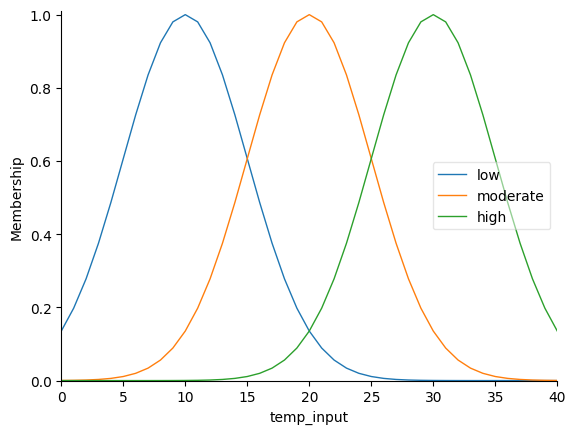

In [7]:
temp_input.view()

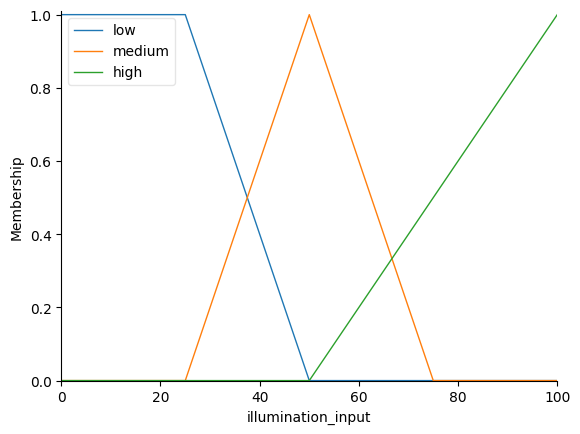

In [8]:
illumination_input.view()

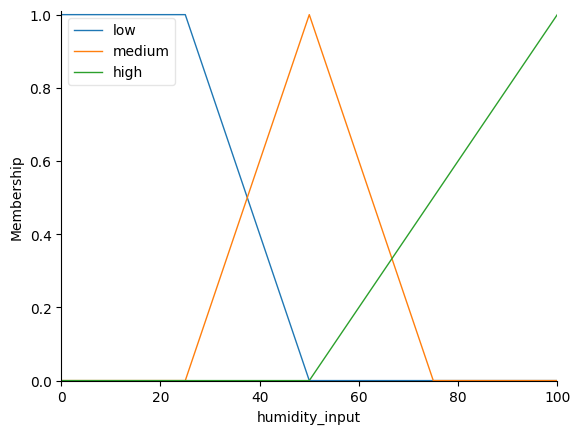

In [9]:
humidity_input.view()

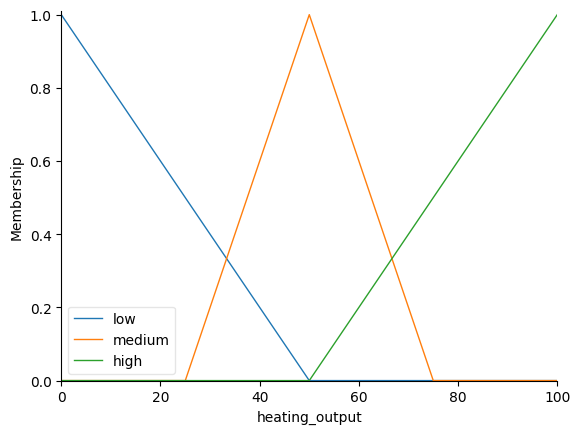

In [10]:
heating_output.view()

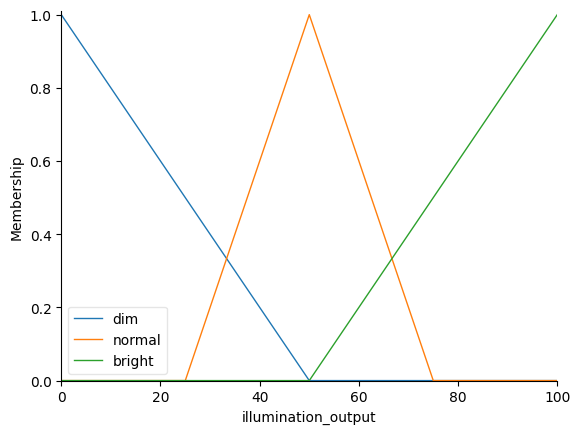

In [11]:
illumination_output.view()

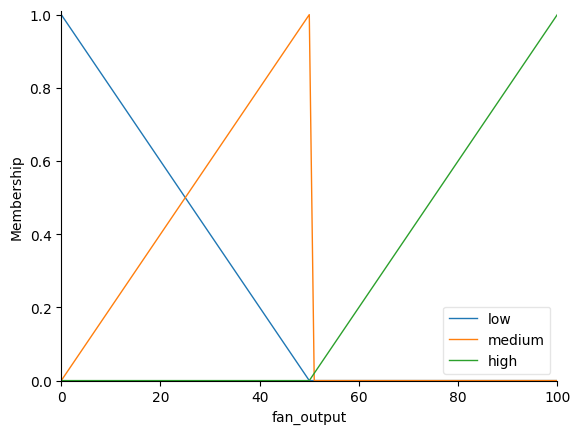

In [12]:
fan_output.view()

In [13]:
# Define fuzzy rules
rule_1 = sf_ctrl.Rule(temp_input['low'] & illumination_input['low'], [heating_output['high'], illumination_output['bright']])
rule_2 = sf_ctrl.Rule(temp_input['high'] & humidity_input['high'], fan_output['high'])
rule_3 = sf_ctrl.Rule(temp_input['low'] & humidity_input['low'], heating_output['high'])
rule_4 = sf_ctrl.Rule(temp_input['moderate'] & illumination_input['medium'], [heating_output['medium'], illumination_output['normal']])
rule_5 = sf_ctrl.Rule(temp_input['high'] & illumination_input['high'], illumination_output['dim'])
rule_6 = sf_ctrl.Rule(temp_input['high'] & humidity_input['low'], fan_output['high'])
rule_7 = sf_ctrl.Rule(temp_input['moderate'] & humidity_input['high'], fan_output['low'])
rule_8 = sf_ctrl.Rule(illumination_input['low'] & humidity_input['medium'], illumination_output['bright'])
rule_9 = sf_ctrl.Rule(temp_input['low'] & humidity_input['high'], fan_output['low'])
rule_10 = sf_ctrl.Rule(temp_input['high'] & humidity_input['medium'], fan_output['medium'])

In [14]:
# Add these new rules to the control system
control_sys = sf_ctrl.ControlSystem([rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8, rule_9, rule_10])
sim_sys = sf_ctrl.ControlSystemSimulation(control_sys)

In [15]:
# Define different test scenarios for input values
test_cases = [
    {'temp_input': 5, 'illumination_input': 20, 'humidity_input': 30},   # Cold, Dim light, Low humidity
    {'temp_input': 22, 'illumination_input': 50, 'humidity_input': 60},  # Warm, Moderate light, Medium humidity
    {'temp_input': 35, 'illumination_input': 80, 'humidity_input': 90},  # Hot, Bright light, High humidity
    {'temp_input': 8, 'illumination_input': 90, 'humidity_input': 20},   # Cold, Bright light, Low humidity
    {'temp_input': 25, 'illumination_input': 10, 'humidity_input': 80},  # Warm, Dim light, High humidity
]

# Iterate over each test scenario and run the simulation
for case in test_cases:
    sim_sys.input['temp_input'] = case['temp_input']
    sim_sys.input['illumination_input'] = case['illumination_input']
    sim_sys.input['humidity_input'] = case['humidity_input']

    # Run the simulation
    sim_sys.compute()

    # Safely access the outputs with a default value
    heater_res = sim_sys.output.get('heating_output', 'No output')
    light_res = sim_sys.output.get('illumination_output', 'No output')
    fan_res = sim_sys.output.get('fan_output', 'No output')

    # Print the results for each scenario
    print(f"Scenario: {case}")
    print(f"Heating output: {heater_res}")
    print(f"Lighting output: {light_res}")
    print(f"Fan output: {fan_res}")
    print("\n")

Scenario: {'temp_input': 5, 'illumination_input': 20, 'humidity_input': 30}
Heating output: 81.48162267526405
Lighting output: 81.48162267526405
Fan output: 50.00004658315025


Scenario: {'temp_input': 22, 'illumination_input': 50, 'humidity_input': 60}
Heating output: 49.99999999999999
Lighting output: 49.99999999999999
Fan output: 47.30775848097909


Scenario: {'temp_input': 35, 'illumination_input': 80, 'humidity_input': 90}
Heating output: No output
Lighting output: 18.571428571428573
Fan output: 80.0391756968907


Scenario: {'temp_input': 8, 'illumination_input': 90, 'humidity_input': 20}
Heating output: 83.24184873371875
Lighting output: 24.999218489346493
Fan output: 75.00078151065344


Scenario: {'temp_input': 25, 'illumination_input': 10, 'humidity_input': 80}
Heating output: 75.13860391691054
Lighting output: 75.13860391691054
Fan output: 49.999999999999964




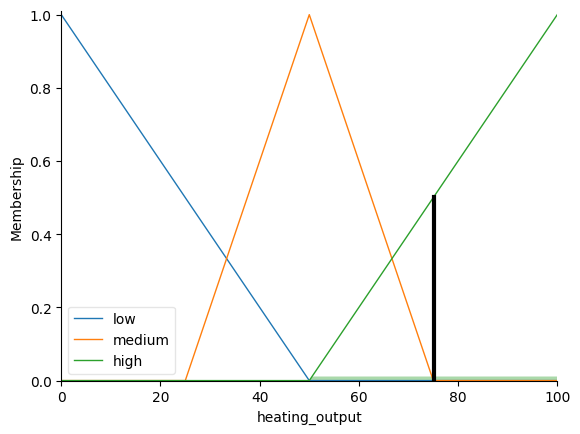

In [16]:
heating_output.view(sim=sim_sys)

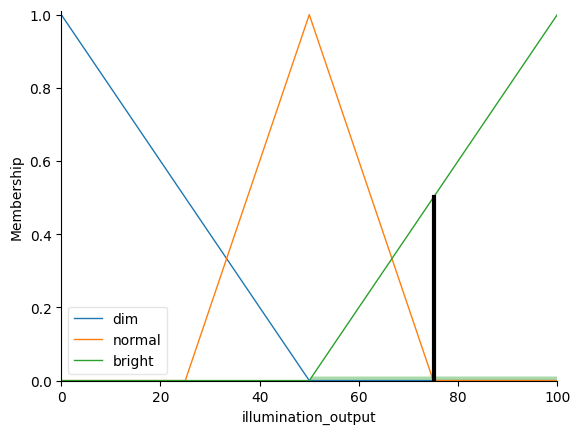

In [17]:
illumination_output.view(sim=sim_sys)

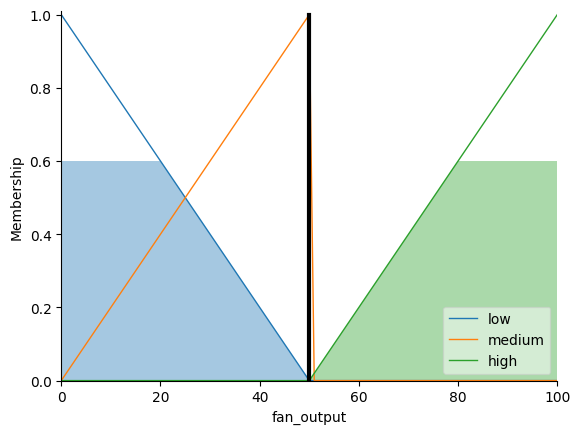

In [18]:
fan_output.view(sim=sim_sys)

In [19]:
# Import matplotlib for visualization (already imported earlier)
import matplotlib.pyplot as plt

# Lists to store the output results for visualization
heating_outputs = []
lighting_outputs = []
fan_outputs = []
scenarios = []

# Iterate over each test scenario, run the simulation, and collect results
for case in test_cases:
    sim_sys.input['temp_input'] = case['temp_input']
    sim_sys.input['illumination_input'] = case['illumination_input']
    sim_sys.input['humidity_input'] = case['humidity_input']

    # Run the simulation
    sim_sys.compute()

    # Collect results
    heater_res = sim_sys.output.get('heating_output', 0)
    light_res = sim_sys.output.get('illumination_output', 0)
    fan_res = sim_sys.output.get('fan_output', 0)

    # Append results to the lists
    heating_outputs.append(heater_res)
    lighting_outputs.append(light_res)
    fan_outputs.append(fan_res)
    scenarios.append(f"Temp: {case['temp_input']}, Light: {case['illumination_input']}, Humidity: {case['humidity_input']}")

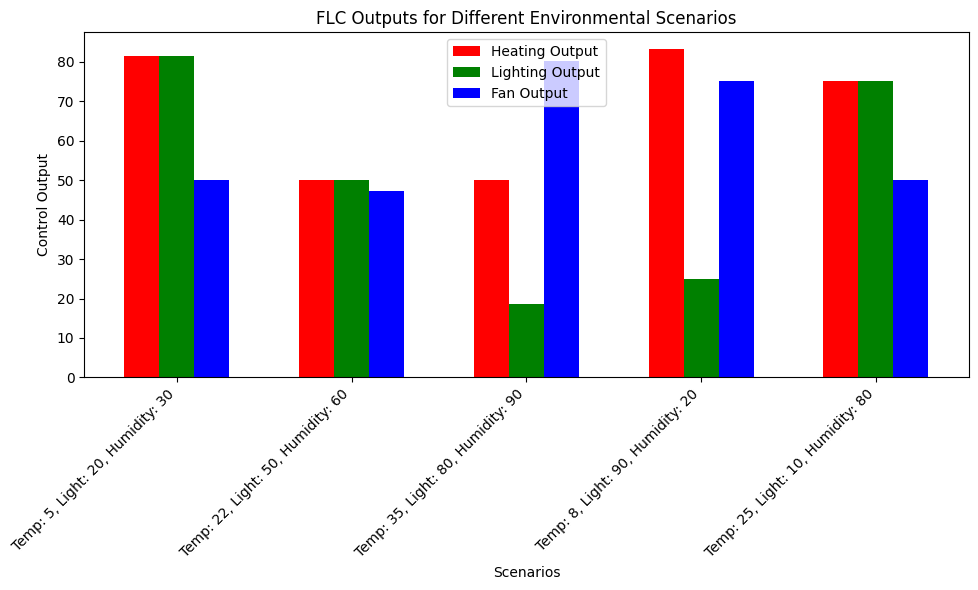

In [20]:
# Create a bar plot to compare the outputs
bar_width = 0.2
index = np.arange(len(test_cases))

plt.figure(figsize=(10, 6))

# Plot Heating output
plt.bar(index, heating_outputs, bar_width, label='Heating Output', color='r')

# Plot Lighting output
plt.bar(index + bar_width, lighting_outputs, bar_width, label='Lighting Output', color='g')

# Plot Fan output
plt.bar(index + 2 * bar_width, fan_outputs, bar_width, label='Fan Output', color='b')

# Set the labels, title, and legend
plt.xlabel('Scenarios')
plt.ylabel('Control Output')
plt.title('FLC Outputs for Different Environmental Scenarios')
plt.xticks(index + bar_width, scenarios, rotation=45, ha="right")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
# After sim_sys.compute() in your loop, add this line to inspect outputs
print("Available output keys:", sim_sys.output.keys())

Available output keys: dict_keys(['heating_output', 'illumination_output', 'fan_output'])


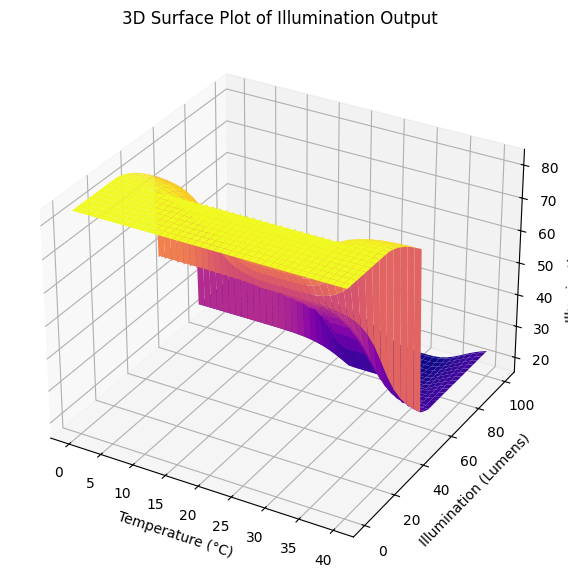

In [22]:
# Create a meshgrid for the inputs
temp_mesh, illumination_mesh = np.meshgrid(temp_range, illumination_range)

# Calculate illumination output for the meshgrid
illumination_output_mesh = np.zeros(temp_mesh.shape)

# Iterate over each point in the meshgrid
for i in range(temp_mesh.shape[0]):
    for j in range(temp_mesh.shape[1]):
        sim_sys.input['temp_input'] = temp_mesh[i, j]
        sim_sys.input['illumination_input'] = illumination_mesh[i, j]
        sim_sys.input['humidity_input'] = 50  # Assuming a fixed humidity value for this plot
        sim_sys.compute()
        illumination_output_mesh[i, j] = sim_sys.output['illumination_output']

# Plotting the 3D surface for illumination output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(temp_mesh, illumination_mesh, illumination_output_mesh, cmap='plasma')

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Illumination (Lumens)')
ax.set_zlabel('Illumination Output')
ax.set_title('3D Surface Plot of Illumination Output')
plt.show()

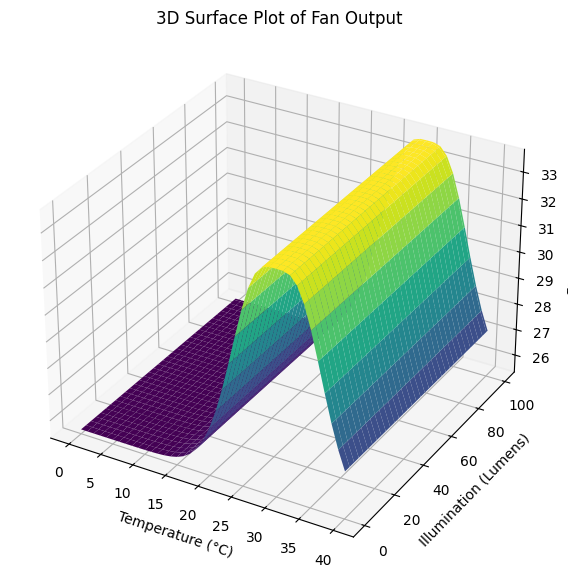

In [23]:
# Create a meshgrid for the inputs
temp_mesh, illumination_mesh = np.meshgrid(temp_range, illumination_range)

# Calculate fan output for the meshgrid
fan_output_mesh = np.zeros(temp_mesh.shape)

# Iterate over each point in the meshgrid
for i in range(temp_mesh.shape[0]):
    for j in range(temp_mesh.shape[1]):
        sim_sys.input['temp_input'] = temp_mesh[i, j]
        sim_sys.input['illumination_input'] = illumination_mesh[i, j]
        sim_sys.input['humidity_input'] = 50  # Assuming a fixed humidity value for this plot
        sim_sys.compute()

        # Safely access the fan output
        fan_output_mesh[i, j] = sim_sys.output.get('fan_output', 0)

# Plotting the 3D surface for fan output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(temp_mesh, illumination_mesh, fan_output_mesh, cmap='viridis')

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Illumination (Lumens)')
ax.set_zlabel('Fan Output')
ax.set_title('3D Surface Plot of Fan Output')
plt.show()

## Part 2 - FLC Optimization Using Genetic Algorithms

In [24]:
# Define the Fuzzy Logic Controller class
class FuzzyLogicController:
    def __init__(self):
        self.input = {'temp': 0, 'illumination': 0, 'humidity': 0}
        self.output = {'heater': 0, 'light_output': 0, 'fan': 0}
        
        # Placeholder for fuzzy sets and universe of discourse
        self.temp_cold = None
        self.temp_warm = None
        self.temp_hot = None

        self.light_dim = None
        self.light_moderate = None
        self.light_bright = None

        self.humidity_low = None
        self.humidity_medium = None
        self.humidity_high = None

        self.heater_low = None
        self.heater_medium = None
        self.heater_high = None

        self.light_output_dim = None
        self.light_output_moderate = None
        self.light_output_bright = None

        self.fan_low = None
        self.fan_high = None

        self.x_range = np.arange(0, 181, 1)  # Extended to 180 to accommodate fan up to 170

    def compute(self):
        # Get the input values
        temp = self.input['temp']
        illumination = self.input['illumination']
        humidity = self.input['humidity']

        # Use fuzzy membership functions defined by the chromosome
        temp_level_cold = sf.interp_membership(self.x_range, self.temp_cold, temp)
        temp_level_warm = sf.interp_membership(self.x_range, self.temp_warm, temp)
        temp_level_hot = sf.interp_membership(self.x_range, self.temp_hot, temp)

        light_level_dim = sf.interp_membership(self.x_range, self.light_dim, illumination)
        light_level_moderate = sf.interp_membership(self.x_range, self.light_moderate, illumination)
        light_level_bright = sf.interp_membership(self.x_range, self.light_bright, illumination)

        humidity_level_low = sf.interp_membership(self.x_range, self.humidity_low, humidity)
        humidity_level_medium = sf.interp_membership(self.x_range, self.humidity_medium, humidity)
        humidity_level_high = sf.interp_membership(self.x_range, self.humidity_high, humidity)

        # Example of fuzzy rules:
        # Rule 1: If temperature is cold and light is dim, then heater is high and light_output is bright and fan is low
        heater_activation_high = min(temp_level_cold, light_level_dim)
        light_output_activation_bright = min(temp_level_cold, light_level_dim)
        fan_activation_low = min(temp_level_cold, light_level_dim)

        # Rule 2: If temperature is hot and humidity is high, then fan is high
        fan_activation_high = min(temp_level_hot, humidity_level_high)

        # Aggregate all activations
        heater_activation = heater_activation_high  # Currently only one rule affects heater
        light_output_activation = light_output_activation_bright  # Currently only one rule affects light_output
        fan_activation = max(fan_activation_low, fan_activation_high)  # Combining multiple fan activations

        # Apply the activations to the corresponding fuzzy sets
        # For Heater: High and Low (assuming low is default)
        heater_mfx = heater_activation * self.heater_high + (1 - heater_activation) * self.heater_low

        # For Light Output: Bright and Dim (assuming dim is default)
        light_output_mfx = light_output_activation * self.light_output_bright + (1 - light_output_activation) * self.light_output_dim

        # For Fan: High and Low
        fan_mfx = fan_activation * self.fan_high + (1 - fan_activation) * self.fan_low

        # Defuzzify to get crisp output
        self.output['heater'] = sf.defuzz(self.x_range, heater_mfx, 'centroid')
        self.output['light_output'] = sf.defuzz(self.x_range, light_output_mfx, 'centroid')
        self.output['fan'] = sf.defuzz(self.x_range, fan_mfx, 'centroid')

In [25]:
# Population initialization
def initialize_population(pop_size, chromosome_length):
    population = []
    for _ in range(pop_size):
        chromosome = [random.uniform(0, 180) for _ in range(chromosome_length)]

        # Ensure that the temperature, illumination, humidity, heater, light_output, and fan sets are sorted
        # Temperature: 3 sets (cold, warm, hot) with 2 parameters each (mean, sigma) for gaussmf
        chromosome[0:6] = sorted(chromosome[0:6])

        # Illumination: 3 sets (dim, moderate, bright) with 4 parameters each for trapmf
        illumination_dim = sorted(chromosome[6:10])
        illumination_moderate = sorted(chromosome[10:14])
        illumination_bright = sorted(chromosome[14:18])
        chromosome[6:18] = illumination_dim + illumination_moderate + illumination_bright

        # Humidity: 3 sets (low, medium, high) with 4 parameters each for trapmf
        humidity_low = sorted(chromosome[18:22])
        humidity_medium = sorted(chromosome[22:26])
        humidity_high = sorted(chromosome[26:30])
        chromosome[18:30] = humidity_low + humidity_medium + humidity_high

        # Heater: 3 sets (low, medium, high) with 3 parameters each for trimf
        heater_low = sorted(chromosome[30:33])
        heater_medium = sorted(chromosome[33:36])
        heater_high = sorted(chromosome[36:39])
        chromosome[30:39] = heater_low + heater_medium + heater_high

        # Light Output: 3 sets (dim, moderate, bright) with 3 parameters each for trimf
        light_output_dim = sorted(chromosome[39:42])
        light_output_moderate = sorted(chromosome[42:45])
        light_output_bright = sorted(chromosome[45:48])
        chromosome[39:48] = light_output_dim + light_output_moderate + light_output_bright

        # Fan: 2 sets (low, high) with 3 parameters each for trimf
        fan_low = sorted(chromosome[48:51])
        fan_high = sorted(chromosome[51:54])
        chromosome[48:54] = fan_low + fan_high

        population.append(chromosome)
    return population

In [26]:
chromosome_length = 54  # Updated to 54 to accommodate all fuzzy sets

def apply_chromosome_to_flc(chromosome, flc):
    print("Chromosome values:", chromosome)

    # Define the universe of discourse for the fuzzy sets (e.g., from 0 to 180 for fan)
    x_range = flc.x_range  # np.arange(0, 181, 1)

    # Apply to temperature fuzzy sets (gaussmf with mean and sigma)
    temp_mean_cold, temp_sigma_cold, temp_mean_warm, temp_sigma_warm, temp_mean_hot, temp_sigma_hot = chromosome[0:6]
    flc.temp_cold = sf.gaussmf(x_range, temp_mean_cold, temp_sigma_cold)
    flc.temp_warm = sf.gaussmf(x_range, temp_mean_warm, temp_sigma_warm)
    flc.temp_hot = sf.gaussmf(x_range, temp_mean_hot, temp_sigma_hot)

    # Apply to illumination fuzzy sets (trapmf)
    illumination_dim = chromosome[6:10]
    illumination_moderate = chromosome[10:14]
    illumination_bright = chromosome[14:18]
    flc.light_dim = sf.trapmf(x_range, illumination_dim)
    flc.light_moderate = sf.trapmf(x_range, illumination_moderate)
    flc.light_bright = sf.trapmf(x_range, illumination_bright)

    # Apply to humidity fuzzy sets (trapmf)
    humidity_low = chromosome[18:22]
    humidity_medium = chromosome[22:26]
    humidity_high = chromosome[26:30]
    flc.humidity_low = sf.trapmf(x_range, humidity_low)
    flc.humidity_medium = sf.trapmf(x_range, humidity_medium)
    flc.humidity_high = sf.trapmf(x_range, humidity_high)

    # Apply to heater fuzzy sets (trimf)
    heater_low = chromosome[30:33]
    heater_medium = chromosome[33:36]
    heater_high = chromosome[36:39]
    flc.heater_low = sf.trimf(x_range, heater_low)
    flc.heater_medium = sf.trimf(x_range, heater_medium)
    flc.heater_high = sf.trimf(x_range, heater_high)

    # Apply to light_output fuzzy sets (trimf)
    light_output_dim = chromosome[39:42]
    light_output_moderate = chromosome[42:45]
    light_output_bright = chromosome[45:48]
    flc.light_output_dim = sf.trimf(x_range, light_output_dim)
    flc.light_output_moderate = sf.trimf(x_range, light_output_moderate)
    flc.light_output_bright = sf.trimf(x_range, light_output_bright)

    # Apply to fan fuzzy sets (trimf)
    fan_low = chromosome[48:51]
    fan_high = chromosome[51:54]
    flc.fan_low = sf.trimf(x_range, fan_low)
    flc.fan_high = sf.trimf(x_range, fan_high)

    return flc

In [27]:
# Fitness function evaluation
def fitness_function(chromosome, dataset, flc):
    try:
        apply_chromosome_to_flc(chromosome, flc)  # Apply chromosome to FLC
    except ValueError as e:
        print("Chromosome application error:", e)
        return float('inf')  # Assign a high error if chromosome is invalid

    total_error = 0
    for idx, sample in enumerate(dataset):
        temperature, light, humidity = sample['inputs']
        expected_outputs = sample['outputs']

        # Run the FLC
        flc.input['temperature'] = temperature
        flc.input['light'] = light
        flc.input['humidity'] = humidity
        flc.compute()

        # Debugging: Print computed outputs
        print(f"Sample {idx}:")
        print(f"Inputs -> Temperature: {temperature}, Light: {light}, Humidity: {humidity}")
        print(f"FLC Outputs -> Heater: {flc.output['heater']:.2f}, Light Output: {flc.output['light_output']:.2f}, Fan: {flc.output['fan']:.2f}")
        print(f"Expected -> Heater: {expected_outputs['heater']}, Light Output: {expected_outputs['light_output']}, Fan: {expected_outputs['fan']}\n")

        # Compute error (squared error)
        heater_error = (flc.output.get('heater', 0) - expected_outputs['heater']) ** 2
        light_error = (flc.output.get('light_output', 0) - expected_outputs['light_output']) ** 2
        fan_error = (flc.output.get('fan', 0) - expected_outputs['fan']) ** 2

        print(f"Errors -> Heater: {heater_error:.2f}, Light Output: {light_error:.2f}, Fan: {fan_error:.2f}\n")

        total_error += heater_error + light_error + fan_error

    average_error = total_error / len(dataset)
    print(f"Total Error for chromosome: {total_error:.2f}, Average Error: {average_error:.2f}\n")
    return average_error

In [28]:
# Crossover
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]

    # Ensure valid fuzzy set values by sorting the respective segments
    # Temperature: first 6 genes (3 gaussmf: mean and sigma)
    child1[0:6] = sorted(child1[0:6])
    child2[0:6] = sorted(child2[0:6])

    # Light: next 12 genes (3 trapmf: a, b, c, d)
    light_dim = sorted(child1[6:10])
    light_moderate = sorted(child1[10:14])
    light_bright = sorted(child1[14:18])
    child1[6:18] = light_dim + light_moderate + light_bright

    light_dim = sorted(child2[6:10])
    light_moderate = sorted(child2[10:14])
    light_bright = sorted(child2[14:18])
    child2[6:18] = light_dim + light_moderate + light_bright

    # Humidity: next 12 genes (3 trapmf: a, b, c, d)
    humidity_low = sorted(child1[18:22])
    humidity_medium = sorted(child1[22:26])
    humidity_high = sorted(child1[26:30])
    child1[18:30] = humidity_low + humidity_medium + humidity_high

    humidity_low = sorted(child2[18:22])
    humidity_medium = sorted(child2[22:26])
    humidity_high = sorted(child2[26:30])
    child2[18:30] = humidity_low + humidity_medium + humidity_high

    # Heater: next 9 genes (3 trimf: a, b, c)
    heater_low = sorted(child1[30:33])
    heater_medium = sorted(child1[33:36])
    heater_high = sorted(child1[36:39])
    child1[30:39] = heater_low + heater_medium + heater_high

    heater_low = sorted(child2[30:33])
    heater_medium = sorted(child2[33:36])
    heater_high = sorted(child2[36:39])
    child2[30:39] = heater_low + heater_medium + heater_high

    # Light Output: next 9 genes (3 trimf: a, b, c)
    light_output_dim = sorted(child1[39:42])
    light_output_moderate = sorted(child1[42:45])
    light_output_bright = sorted(child1[45:48])
    child1[39:48] = light_output_dim + light_output_moderate + light_output_bright

    light_output_dim = sorted(child2[39:42])
    light_output_moderate = sorted(child2[42:45])
    light_output_bright = sorted(child2[45:48])
    child2[39:48] = light_output_dim + light_output_moderate + light_output_bright

    # Fan: last 6 genes (2 trimf: a, b, c)
    fan_low = sorted(child1[48:51])
    fan_high = sorted(child1[51:54])
    child1[48:54] = fan_low + fan_high

    fan_low = sorted(child2[48:51])
    fan_high = sorted(child2[51:54])
    child2[48:54] = fan_low + fan_high

    return child1, child2

In [29]:
# Mutation
def mutate(chromosome, mutation_rate):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            # Mutate based on the type of fuzzy set
            if i < 6:
                # Temperature gaussmf: mean and sigma
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 6 <= i < 18:
                # Light trapmf: a, b, c, d
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 18 <= i < 30:
                # Humidity trapmf: a, b, c, d
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 30 <= i < 39:
                # Heater trimf: a, b, c
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 39 <= i < 48:
                # Light Output trimf: a, b, c
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))
            elif 48 <= i < 54:
                # Fan trimf: a, b, c
                chromosome[i] += random.uniform(-5, 5)
                chromosome[i] = max(0, min(180, chromosome[i]))

    # Ensure the values for fuzzy sets are sorted after mutation
    # Temperature: first 6 genes (3 gaussmf: mean and sigma)
    chromosome[0:6] = sorted(chromosome[0:6])

    # Light: next 12 genes (3 trapmf: a, b, c, d)
    light_dim = sorted(chromosome[6:10])
    light_moderate = sorted(chromosome[10:14])
    light_bright = sorted(chromosome[14:18])
    chromosome[6:18] = light_dim + light_moderate + light_bright

    # Humidity: next 12 genes (3 trapmf: a, b, c, d)
    humidity_low = sorted(chromosome[18:22])
    humidity_medium = sorted(chromosome[22:26])
    humidity_high = sorted(chromosome[26:30])
    chromosome[18:30] = humidity_low + humidity_medium + humidity_high

    # Heater: next 9 genes (3 trimf: a, b, c)
    heater_low = sorted(chromosome[30:33])
    heater_medium = sorted(chromosome[33:36])
    heater_high = sorted(chromosome[36:39])
    chromosome[30:39] = heater_low + heater_medium + heater_high

    # Light Output: next 9 genes (3 trimf: a, b, c)
    light_output_dim = sorted(chromosome[39:42])
    light_output_moderate = sorted(chromosome[42:45])
    light_output_bright = sorted(chromosome[45:48])
    chromosome[39:48] = light_output_dim + light_output_moderate + light_output_bright

    # Fan: last 6 genes (2 trimf: a, b, c)
    fan_low = sorted(chromosome[48:51])
    fan_high = sorted(chromosome[51:54])
    chromosome[48:54] = fan_low + fan_high

    return chromosome

In [30]:
# Select parents using tournament selection
def select_parents(population, fitness_scores):
    tournament_size = 5
    
    # Select first parent
    selected_indices = random.sample(range(len(population)), min(tournament_size, len(population)))
    selected_fitness = [fitness_scores[i] for i in selected_indices]
    parent1 = population[selected_indices[selected_fitness.index(min(selected_fitness))]]

    # Select second parent
    selected_indices = random.sample(range(len(population)), min(tournament_size, len(population)))
    selected_fitness = [fitness_scores[i] for i in selected_indices]
    parent2 = population[selected_indices[selected_fitness.index(min(selected_fitness))]]

    return parent1, parent2

In [31]:
# Genetic Algorithm
def genetic_algorithm(pop_size, generations, mutation_rate, dataset, chromosome_length):
    population = initialize_population(pop_size, chromosome_length)

    # Initialize the FLC
    flc = FuzzyLogicController()
    best_fitness_values = []

    for generation in range(generations):
        print(f"Generation {generation + 1}/{generations}")
        # Evaluate fitness
        fitness_scores = [fitness_function(chromosome, dataset, flc) for chromosome in population]

        # Find and print the best fitness in the current generation
        best_fitness = min(fitness_scores)
        best_index = fitness_scores.index(best_fitness)
        print(f"Best fitness in generation {generation + 1}: {best_fitness}\n")
        # Store the best fitness value
        best_fitness_values.append(best_fitness)

        # Select parents and generate next generation
        next_population = []
        while len(next_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            next_population.append(mutate(child1, mutation_rate))
            if len(next_population) < pop_size:
                next_population.append(mutate(child2, mutation_rate))

        population = next_population

    # Return the best chromosome after evolution
    final_fitness_scores = [fitness_function(chromosome, dataset, flc) for chromosome in population]
    best_chromosome = population[final_fitness_scores.index(min(final_fitness_scores))]
    return best_chromosome, best_fitness_values

In [32]:
# Load the dataset from the CSV file
df = pd.read_csv('dataset.csv')

# Convert the DataFrame to the desired format
dataset = []
for index, row in df.iterrows():
    dataset.append({
        'inputs': (row['temperature'], row['light'], row['humidity']),
        'outputs': {
            'heater': row['heater'],
            'light_output': row['light_output'],
            'fan': row['fan']
        }
    })

# Now dataset is ready to be used
print(dataset)

[{'inputs': (5, 20, 30), 'outputs': {'heater': 70, 'light_output': 80, 'fan': 30}}, {'inputs': (10, 25, 40), 'outputs': {'heater': 65, 'light_output': 75, 'fan': 40}}, {'inputs': (15, 30, 50), 'outputs': {'heater': 60, 'light_output': 70, 'fan': 50}}, {'inputs': (20, 35, 60), 'outputs': {'heater': 55, 'light_output': 65, 'fan': 60}}, {'inputs': (25, 40, 70), 'outputs': {'heater': 50, 'light_output': 60, 'fan': 70}}, {'inputs': (30, 45, 80), 'outputs': {'heater': 45, 'light_output': 55, 'fan': 80}}, {'inputs': (35, 50, 90), 'outputs': {'heater': 40, 'light_output': 50, 'fan': 90}}, {'inputs': (40, 55, 100), 'outputs': {'heater': 35, 'light_output': 45, 'fan': 100}}, {'inputs': (45, 60, 110), 'outputs': {'heater': 30, 'light_output': 40, 'fan': 110}}, {'inputs': (50, 65, 120), 'outputs': {'heater': 25, 'light_output': 35, 'fan': 120}}, {'inputs': (55, 70, 130), 'outputs': {'heater': 20, 'light_output': 30, 'fan': 130}}, {'inputs': (60, 75, 140), 'outputs': {'heater': 15, 'light_output': 

In [33]:
# Run the genetic algorithm
best_chromosome, best_fitness_values = genetic_algorithm(
    pop_size=20,
    generations=50,
    mutation_rate=0.1,
    dataset=dataset,
    chromosome_length=54
)

Generation 1/50
Chromosome values: [25.55910005656767, 26.79576255064311, 70.41657665923566, 127.80092117610924, 152.64880733921552, 158.38455691855435, 0.5708684996902424, 39.7196408407778, 79.97181018510862, 130.91334496969097, 37.07374840189166, 73.3697091194244, 123.86509680021753, 143.15198616313447, 21.765146189801065, 44.741780923018254, 151.57067090835602, 172.97606631788017, 19.746581893381364, 25.566624728909368, 150.8860240159113, 165.5949564822504, 14.31870145882592, 40.95945650366857, 83.34704984819786, 146.60985399124888, 104.50694180167204, 112.97390842171451, 140.5600639024015, 160.02092841029997, 117.11207370720383, 128.94594908186406, 153.40140436442513, 66.51946111780923, 88.03572515802794, 171.59056265678907, 5.557409214341387, 116.3921793114574, 121.88574458835403, 64.16929647717886, 109.29465025719409, 157.75839074461473, 71.89790655041769, 110.41104049947613, 170.32320258772538, 11.166626390639507, 98.31331502656533, 113.35699127012931, 139.22947316842033, 140.01

In [34]:
# Best Chromosome
print("Best chromosome found:", best_chromosome)

Best chromosome found: [31.27241678593895, 63.25098231933623, 69.04037556598819, 119.08273091340466, 140.22489101514535, 172.99076048443658, 63.82290673476632, 106.38422123004388, 131.38423220906543, 143.03095755681812, 4.5621404602392115, 34.07651958708494, 55.15236247952059, 79.4281504029405, 40.331426987550564, 69.8374320930795, 134.75357737752591, 136.00800463685644, 58.13659040930969, 74.99519770176248, 85.12506464140627, 93.50337854562065, 63.359202536805014, 75.54590267212143, 85.384689280101, 134.30544121961938, 0, 38.51828207730537, 48.50084843364556, 114.98684479914832, 13.377765422968949, 18.50204292297763, 74.59604214743806, 40.12079097554236, 118.46437916281185, 177.0787245424894, 35.746559343512146, 85.42220191938644, 167.53719460028773, 0, 25.679322074483224, 107.72050108344753, 143.92201753555744, 151.83030361276985, 154.1085670640188, 67.07177294802214, 96.32382681740043, 176.0276386787918, 134.2333548948875, 144.59926381446664, 161.4012400699589, 9.032170616043835, 35

Chromosome values: [31.27241678593895, 63.25098231933623, 69.04037556598819, 119.08273091340466, 140.22489101514535, 172.99076048443658, 63.82290673476632, 106.38422123004388, 131.38423220906543, 143.03095755681812, 4.5621404602392115, 34.07651958708494, 55.15236247952059, 79.4281504029405, 40.331426987550564, 69.8374320930795, 134.75357737752591, 136.00800463685644, 58.13659040930969, 74.99519770176248, 85.12506464140627, 93.50337854562065, 63.359202536805014, 75.54590267212143, 85.384689280101, 134.30544121961938, 0, 38.51828207730537, 48.50084843364556, 114.98684479914832, 13.377765422968949, 18.50204292297763, 74.59604214743806, 40.12079097554236, 118.46437916281185, 177.0787245424894, 35.746559343512146, 85.42220191938644, 167.53719460028773, 0, 25.679322074483224, 107.72050108344753, 143.92201753555744, 151.83030361276985, 154.1085670640188, 67.07177294802214, 96.32382681740043, 176.0276386787918, 134.2333548948875, 144.59926381446664, 161.4012400699589, 9.032170616043835, 35.403

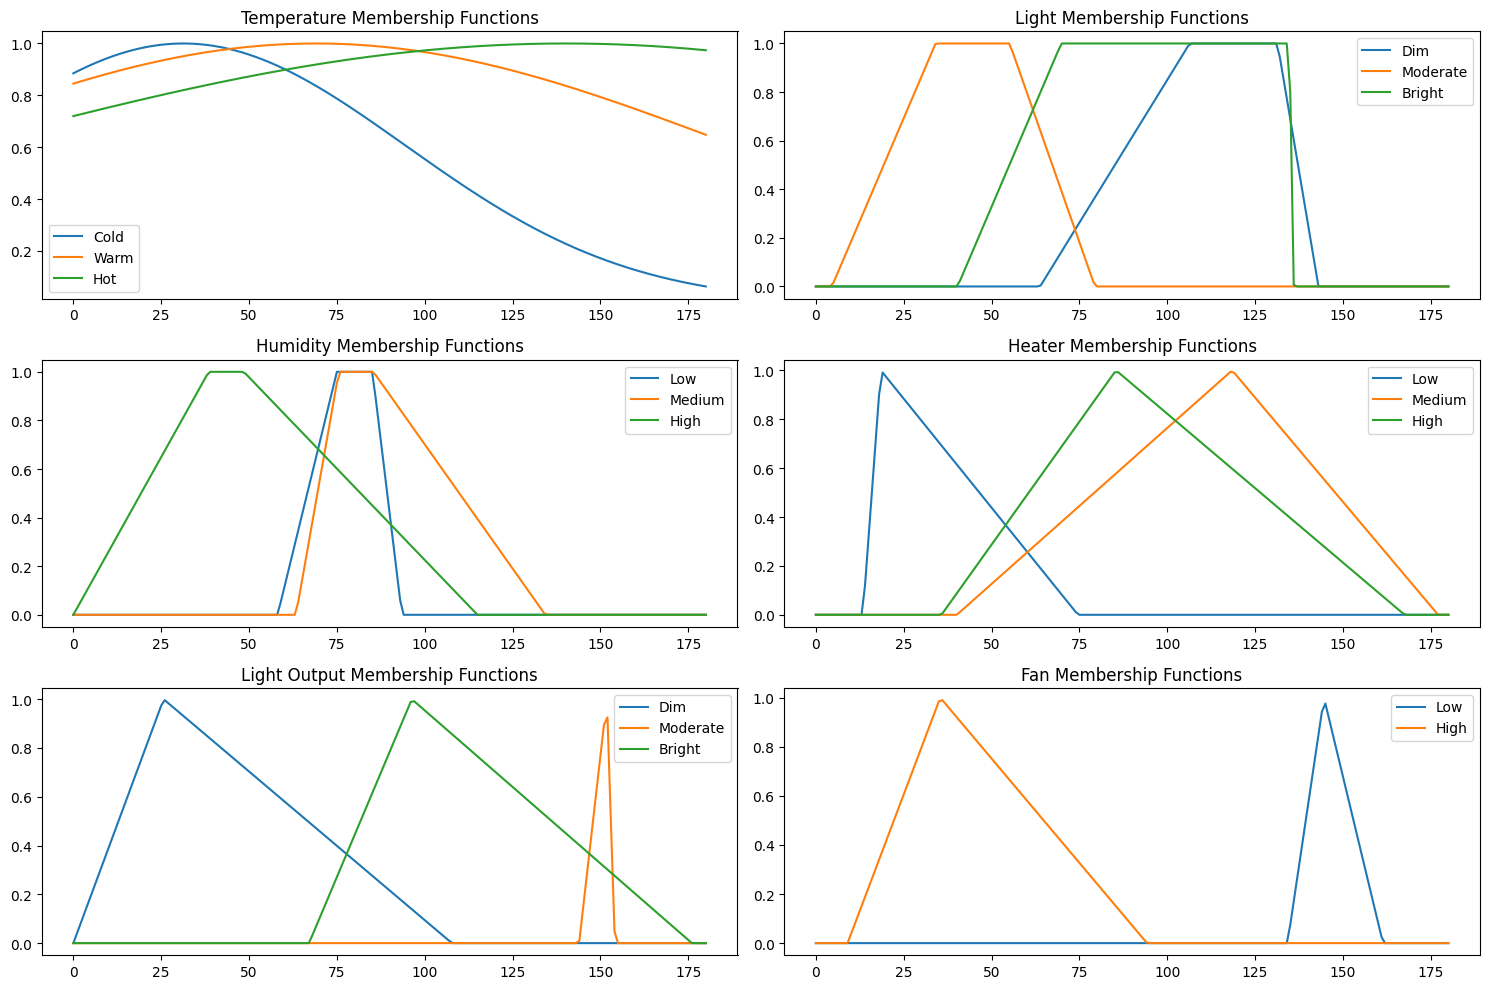

In [35]:
import matplotlib.pyplot as plt

def visualize_membership_functions(flc):
    plt.figure(figsize=(15, 10))

    def plot_membership_function(subplot_position, x_range, membership_values, title, labels):
        plt.subplot(3, 2, subplot_position)
        for values, label in zip(membership_values, labels):
            plt.plot(x_range, values, label=label)
        plt.title(title)
        plt.legend()

    # Temperature
    plot_membership_function(
        subplot_position=1,
        x_range=flc.x_range,
        membership_values=[flc.temp_cold, flc.temp_warm, flc.temp_hot],
        title='Temperature Membership Functions',
        labels=['Cold', 'Warm', 'Hot']
    )

    # Light
    plot_membership_function(
        subplot_position=2,
        x_range=flc.x_range,
        membership_values=[flc.light_dim, flc.light_moderate, flc.light_bright],
        title='Light Membership Functions',
        labels=['Dim', 'Moderate', 'Bright']
    )

    # Humidity
    plot_membership_function(
        subplot_position=3,
        x_range=flc.x_range,
        membership_values=[flc.humidity_low, flc.humidity_medium, flc.humidity_high],
        title='Humidity Membership Functions',
        labels=['Low', 'Medium', 'High']
    )

    # Heater
    plot_membership_function(
        subplot_position=4,
        x_range=flc.x_range,
        membership_values=[flc.heater_low, flc.heater_medium, flc.heater_high],
        title='Heater Membership Functions',
        labels=['Low', 'Medium', 'High']
    )

    # Light Output
    plot_membership_function(
        subplot_position=5,
        x_range=flc.x_range,
        membership_values=[flc.light_output_dim, flc.light_output_moderate, flc.light_output_bright],
        title='Light Output Membership Functions',
        labels=['Dim', 'Moderate', 'Bright']
    )

    # Fan
    plot_membership_function(
        subplot_position=6,
        x_range=flc.x_range,
        membership_values=[flc.fan_low, flc.fan_high],
        title='Fan Membership Functions',
        labels=['Low', 'High']
    )

    plt.tight_layout()
    plt.show()

# Example usage after applying the best chromosome
flc = FuzzyLogicController()
apply_chromosome_to_flc(best_chromosome, flc)
visualize_membership_functions(flc)

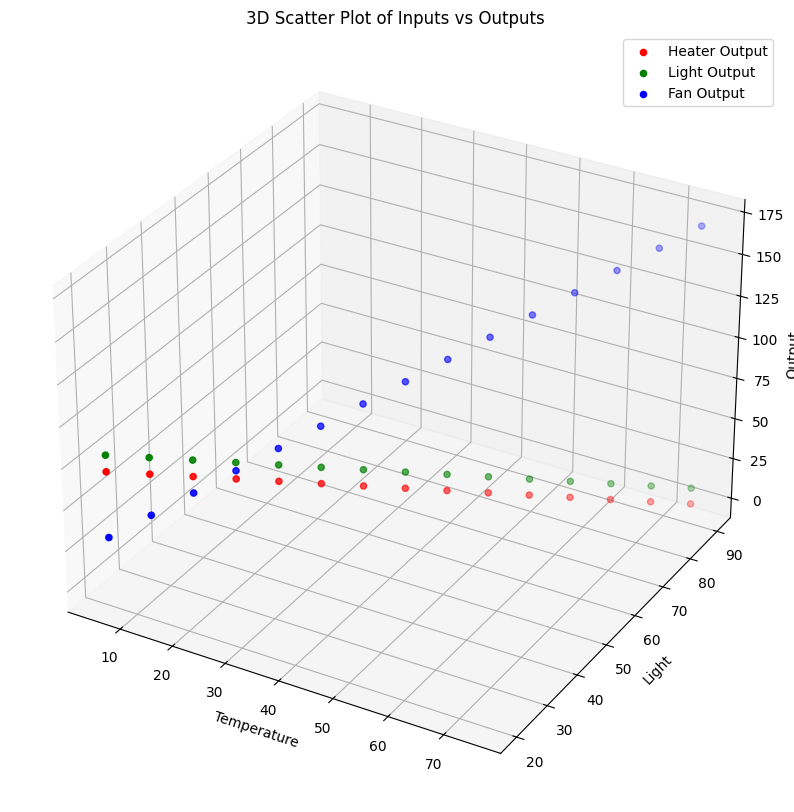

In [36]:
# Extract inputs and outputs from the dataset
inputs = np.array([data['inputs'] for data in dataset])
outputs = np.array([list(data['outputs'].values()) for data in dataset])

# Create a 3D scatter plot for the inputs and outputs
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot heater output
ax.scatter(inputs[:, 0], inputs[:, 1], outputs[:, 0], c='r', label='Heater Output')
# Plot light output
ax.scatter(inputs[:, 0], inputs[:, 1], outputs[:, 1], c='g', label='Light Output')
# Plot fan output
ax.scatter(inputs[:, 0], inputs[:, 1], outputs[:, 2], c='b', label='Fan Output')

ax.set_xlabel('Temperature')
ax.set_ylabel('Light')
ax.set_zlabel('Output')
ax.set_title('3D Scatter Plot of Inputs vs Outputs')
ax.legend()
plt.show()

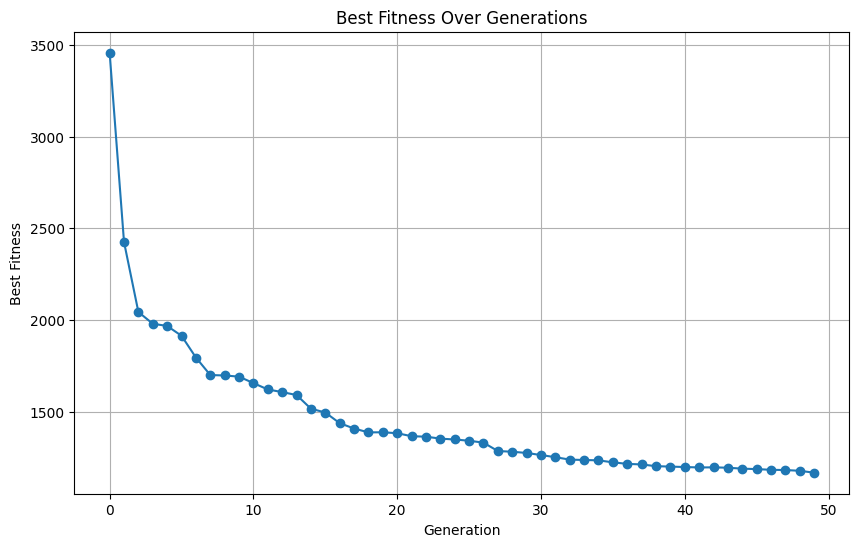

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(best_fitness_values)), best_fitness_values, marker='o')
plt.title('Best Fitness Over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid()
plt.show()

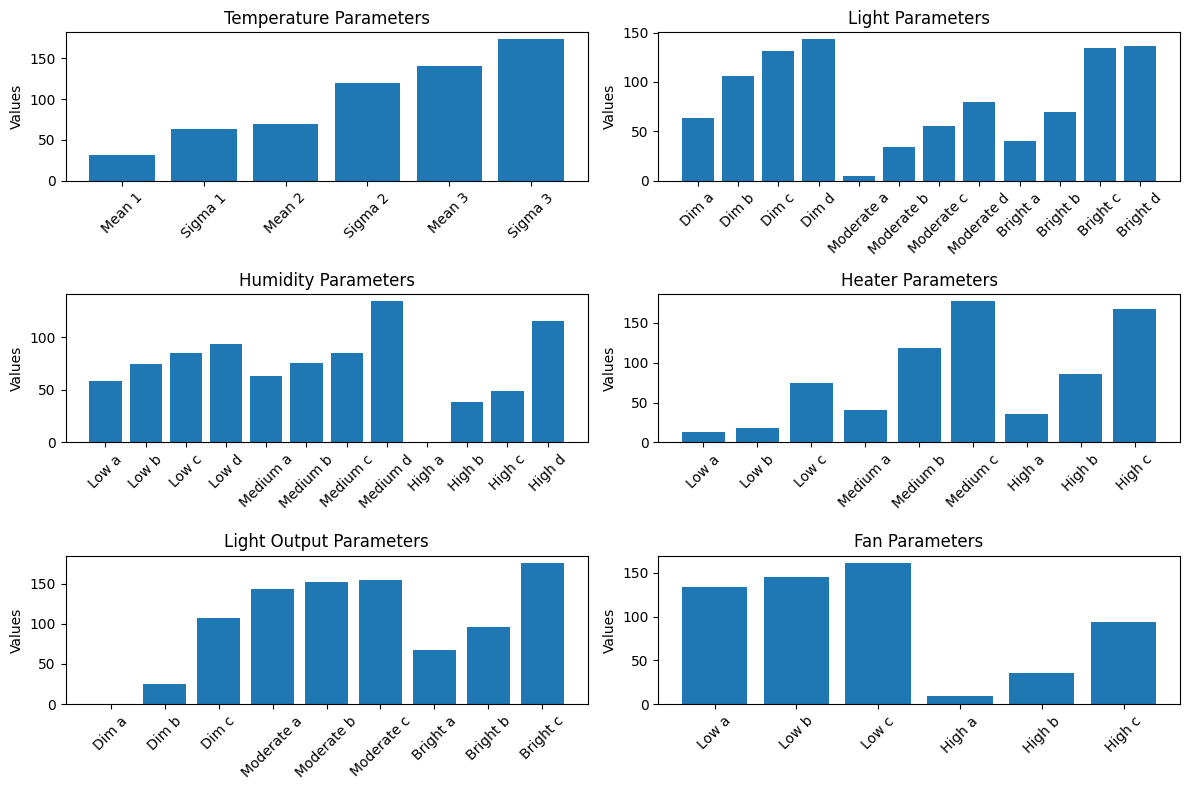

In [38]:
# Assuming best_chromosome contains parameters for temperature, light, humidity, etc.
# For example:
# - First 6 elements: Temperature (mean, sigma)
# - Next 12 elements: Light (a, b, c, d for dim, moderate, bright)
# - Next 12 elements: Humidity (a, b, c, d for low, medium, high)
# - Next 9 elements: Heater (a, b, c for low, medium, high)
# - Next 9 elements: Light Output (a, b, c for dim, moderate, bright)
# - Last 6 elements: Fan (a, b, c for low, high)

# Sample segmentation based on previous context
temperature_params = best_chromosome[0:6]
light_params = best_chromosome[6:18]
humidity_params = best_chromosome[18:30]
heater_params = best_chromosome[30:39]
light_output_params = best_chromosome[39:48]
fan_params = best_chromosome[48:54]

# Plotting the parameters
plt.figure(figsize=(12, 8))

# Temperature
plt.subplot(3, 2, 1)
plt.bar(['Mean 1', 'Sigma 1', 'Mean 2', 'Sigma 2', 'Mean 3', 'Sigma 3'], temperature_params)
plt.title('Temperature Parameters')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Slant x-axis labels

# Light
plt.subplot(3, 2, 2)
plt.bar(['Dim a', 'Dim b', 'Dim c', 'Dim d', 'Moderate a', 'Moderate b', 'Moderate c', 'Moderate d',
         'Bright a', 'Bright b', 'Bright c', 'Bright d'], light_params)
plt.title('Light Parameters')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Slant x-axis labels

# Humidity
plt.subplot(3, 2, 3)
plt.bar(['Low a', 'Low b', 'Low c', 'Low d', 'Medium a', 'Medium b', 'Medium c', 'Medium d',
         'High a', 'High b', 'High c', 'High d'], humidity_params)
plt.title('Humidity Parameters')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Slant x-axis labels

# Heater
plt.subplot(3, 2, 4)
plt.bar(['Low a', 'Low b', 'Low c', 'Medium a', 'Medium b', 'Medium c', 'High a', 'High b', 'High c'], heater_params)
plt.title('Heater Parameters')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Slant x-axis labels

# Light Output
plt.subplot(3, 2, 5)
plt.bar(['Dim a', 'Dim b', 'Dim c', 'Moderate a', 'Moderate b', 'Moderate c', 'Bright a', 'Bright b', 'Bright c'], light_output_params)
plt.title('Light Output Parameters')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Slant x-axis labels

# Fan
plt.subplot(3, 2, 6)
plt.bar(['Low a', 'Low b', 'Low c', 'High a', 'High b', 'High c'], fan_params)
plt.title('Fan Parameters')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Slant x-axis labels

plt.tight_layout()
plt.show()

### Part 3 - CEC' 2005 Function F3 and F7 Comparision

In [39]:
# CEC'2005 Function F3 (Rosenbrock Function)
def F3(x):
    return sum(100 * (x[i + 1] - x[i] ** 2) ** 2 + (1 - x[i]) ** 2 for i in range(len(x) - 1))

In [40]:
# CEC'2005 Function F7 (Lunacek Bi-Rastrigin Function)
def F7(x):
    n = len(x)
    z = [0.5 * (xi + 1) for xi in x]  # Shift the input
    term1 = sum((xi**2 - 10 * np.cos(2 * np.pi * xi) + 10) for xi in z)
    term2 = 100 * (n + 1) + (z[0]**2 + z[1]**2)
    return term1 + term2

In [41]:
# Define bounds for the CEC'2005 problem
def get_bounds(dimension):
    lower_bound = -5.12
    upper_bound = 5.12
    bounds = [(lower_bound, upper_bound) for _ in range(dimension)]
    return bounds

In [42]:
# PSO Optimization function (no c1, c2 parameters)
def pso_optimization(func, dimension, max_iter, swarmsize=50):
    lb, ub = [-5.12]*dimension, [5.12]*dimension
    best_pos, best_val = pso(func, lb, ub, swarmsize=swarmsize, maxiter=max_iter, minfunc=1e-6, minstep=1e-8)
    return best_pos, best_val

In [43]:
# DE Optimization function
def de_optimization(func, dimension, max_iter, popsize=20):
    bounds = get_bounds(dimension)
    result = differential_evolution(func, bounds, maxiter=max_iter, popsize=popsize, disp=True)
    return result.x, result.fun

In [44]:
# Performing multiple trials for each optimizer
def perform_trials(func, optimizer, dimension, max_iter, trials=3, **kwargs):
    results = []
    for i in range(trials):
        best_pos, best_val = optimizer(func, dimension, max_iter, **kwargs)
        print(f"Trial {i + 1}/{trials} completed: Best Value = {best_val}")
        results.append(best_val)
    return np.mean(results), np.std(results)

In [45]:
# Settings
dimension = 30
max_iter = 100
trials = 3
swarmsize = 50
popsize = 20

In [46]:
# Perform PSO and DE on F3
print("Optimizing F3 using PSO and DE:")
mean_val_pso_F3, std_val_pso_F3 = perform_trials(F3, pso_optimization, dimension, max_iter, trials, swarmsize=swarmsize)
mean_val_de_F3, std_val_de_F3 = perform_trials(F3, de_optimization, dimension, max_iter, trials, popsize=popsize)

Optimizing F3 using PSO and DE:
Stopping search: maximum iterations reached --> 100
Trial 1/3 completed: Best Value = 1678.178629724305
Stopping search: maximum iterations reached --> 100
Trial 2/3 completed: Best Value = 2938.203798873621
Stopping search: maximum iterations reached --> 100
Trial 3/3 completed: Best Value = 1787.1544412543426
differential_evolution step 1: f(x)= 127918
differential_evolution step 2: f(x)= 50171
differential_evolution step 3: f(x)= 39399.7
differential_evolution step 4: f(x)= 39399.7
differential_evolution step 5: f(x)= 39399.7
differential_evolution step 6: f(x)= 39399.7
differential_evolution step 7: f(x)= 39399.7
differential_evolution step 8: f(x)= 36421.2
differential_evolution step 9: f(x)= 14888.2
differential_evolution step 10: f(x)= 14888.2
differential_evolution step 11: f(x)= 14888.2
differential_evolution step 12: f(x)= 14888.2
differential_evolution step 13: f(x)= 14888.2
differential_evolution step 14: f(x)= 14888.2
differential_evolution 

In [47]:
# Perform PSO and DE on F7
print("Optimizing F7 using PSO and DE:")
mean_val_pso_F7, std_val_pso_F7 = perform_trials(F7, pso_optimization, dimension, max_iter, trials, swarmsize=swarmsize)
mean_val_de_F7, std_val_de_F7 = perform_trials(F7, de_optimization, dimension, max_iter, trials, popsize=popsize)

Optimizing F7 using PSO and DE:
Stopping search: maximum iterations reached --> 100
Trial 1/3 completed: Best Value = 3181.729414422084
Stopping search: maximum iterations reached --> 100
Trial 2/3 completed: Best Value = 3234.206614062383
Stopping search: maximum iterations reached --> 100
Trial 3/3 completed: Best Value = 3169.789595681115
differential_evolution step 1: f(x)= 3341.02
differential_evolution step 2: f(x)= 3341.02
Polishing solution with 'L-BFGS-B'
Trial 1/3 completed: Best Value = 3279.9568339602315
differential_evolution step 1: f(x)= 3335.86
differential_evolution step 2: f(x)= 3322.67
Polishing solution with 'L-BFGS-B'
Trial 2/3 completed: Best Value = 3161.63740345368
differential_evolution step 1: f(x)= 3322.18
differential_evolution step 2: f(x)= 3314.18
Polishing solution with 'L-BFGS-B'
Trial 3/3 completed: Best Value = 3139.7583150719515


In [48]:
# Display results for F3
print(f"PSO on F3: Mean = {mean_val_pso_F3}, Std = {std_val_pso_F3}")
print(f"DE on F3: Mean = {mean_val_de_F3}, Std = {std_val_de_F3}")

PSO on F3: Mean = 2134.5122899507564, Std = 570.0344802499179
DE on F3: Mean = 1.3288746192667726, Std = 1.8793125072762156


In [49]:
# Display results for F7
print(f"PSO on F7: Mean = {mean_val_pso_F7}, Std = {std_val_pso_F7}")
print(f"DE on F7: Mean = {mean_val_de_F7}, Std = {std_val_de_F7}")

PSO on F7: Mean = 3195.2418747218603, Std = 27.980088179488547
DE on F7: Mean = 3193.7841841619543, Std = 61.5844558691356


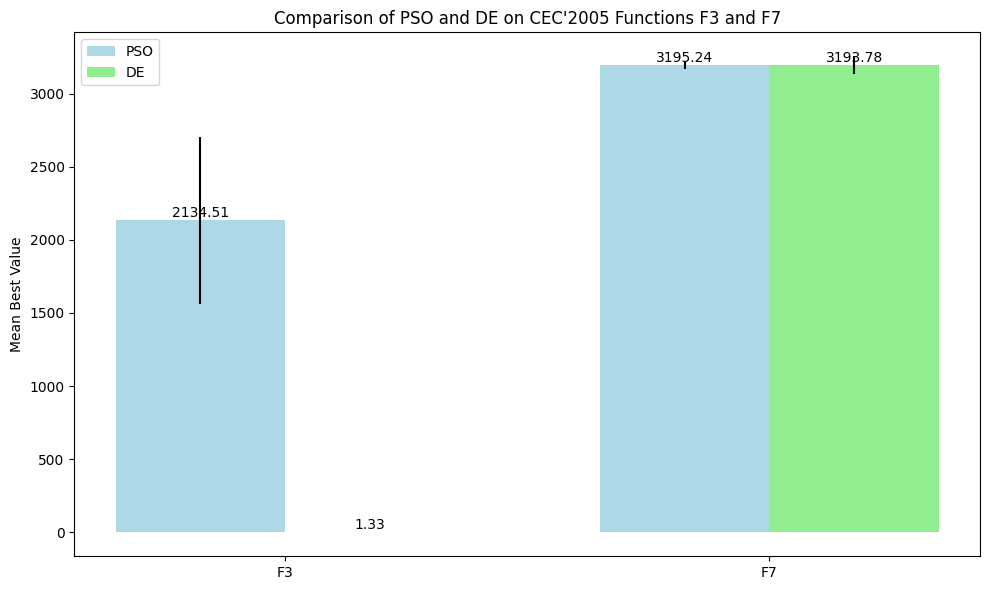

In [50]:
# Visualization
labels = ['F3', 'F7']
pso_means = [mean_val_pso_F3, mean_val_pso_F7]
de_means = [mean_val_de_F3, mean_val_de_F7]
pso_stds = [std_val_pso_F3, std_val_pso_F7]
de_stds = [std_val_de_F3, std_val_de_F7]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plots for PSO
bars1 = ax.bar(x - width / 2, pso_means, width, yerr=pso_stds, label='PSO', color='lightblue')

# Bar plots for DE
bars2 = ax.bar(x + width / 2, de_means, width, yerr=de_stds, label='DE', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Best Value')
ax.set_title('Comparison of PSO and DE on CEC\'2005 Functions F3 and F7')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value annotations on top of the bars
def add_value_annotations(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

add_value_annotations(bars1)
add_value_annotations(bars2)

plt.tight_layout()
plt.show()